 # Steigende Temperaturen in Berlin Tegel

 Die in diesem Notebook genutzten Daten stammen vom [Deutschen Wetterdienst (DWD)](https://www.dwd.de/)
 und werden über das [Climate Data Center (CDC)](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html) zur Verfügung gestellt.
 Konkret werden die
 [historischen](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_00430_19630101_20181231_hist.zip)
 und
 [aktuellen](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_00430_akt.zip)
 täglichen Wetterdaten der DWD Messstation 430 in Berlin Tegel seit 1.1.1963 verwendet.

In [21]:
# ms-python.python added
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks'))
    print(os.getcwd())
except:
    pass

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(rc={'figure.figsize':(20,10)})

data_files = [
    '../data/historisch/produkt_klima_tag_19630101_20181231_00430.txt',
    # '../data/aktuell/produkt_klima_tag_20180215_20190818_00430.txt'
]
df = pd.concat((pd.read_csv(f, 
                            sep=';',
                            header=None,
                            skiprows=1,
                            names=['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK', 'eor'],
                            usecols=['MESS_DATUM', 'RSK', 'TMK'],
                            na_values=['-999'],
                            parse_dates=['MESS_DATUM'],
                            ) for f in data_files), ignore_index=True)
df.index = df['MESS_DATUM']
df = df.drop(columns=['MESS_DATUM'])



In [22]:
def add_source(_ax):
    """Hilfsfunktion um Quellenangabe einem Plot hinzuzufügen"""
    _ax.text(1, 1, 'Quelle: Deutscher Wetterdienst (DWD)', ha='right', va='top', transform=_ax.transAxes)



In [23]:
df.head(5)



,RSK,TMK
MESS_DATUM,,
1963-01-01,0.0,-12.4
1963-01-02,0.0,-10.2
1963-01-03,0.0,-7.2
1963-01-04,1.3,-2.6
1963-01-05,0.0,1.7


In [24]:
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20454 entries, 1963-01-01 to 2018-12-31
Data columns (total 2 columns):
RSK    20453 non-null float64
TMK    20454 non-null float64
dtypes: float64(2)
memory usage: 479.4 KB


In [25]:
df.describe()


,RSK,TMK
count,20453.000000,20454.000000
mean,1.503432,9.851545
std,3.975919,7.914333
min,0.000000,-18.100000
25%,0.000000,3.900000
50%,0.000000,10.000000
75%,1.300000,16.000000
max,196.900000,30.800000


 Man erkennt an der Standardabweichung im Vergleich zu den Mittelwerten,
 dass die Tageswert für Temperatur und Niederschlag wenig hilfreich sein,
 da die Messwerte stark saisonal sind (Jahreszeiten).

 Dies lässt sich für die Temperaturen auch nochmals in einem Boxplot visualisieren.

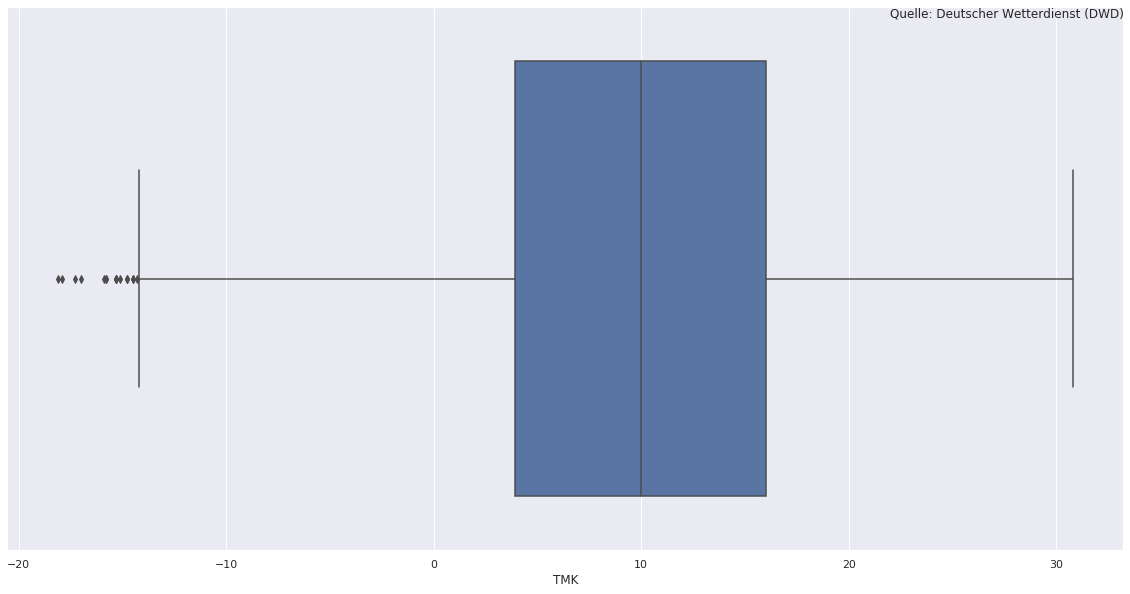

In [26]:
add_source(sns.boxplot(x=df['TMK']))


 Im Fall der Tagestemperaturwerte (TMK) ist es daher sinnvoller, einen jährlichen Durchschnitt zu bilden.

In [27]:
temp_df = df[['TMK']].resample('Y').mean()
temp_df.head(5)



,TMK
MESS_DATUM,
1963-12-31,8.266575
1964-12-31,8.927322
1965-12-31,8.337260
1966-12-31,9.263562
1967-12-31,10.159452


In [28]:
temp_df.describe()



,TMK
count,56.000000
mean,9.851656
std,0.919631
min,8.096448
25%,9.098838
50%,10.023410
75%,10.480392
max,11.595890


In [29]:
temp_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 1963-12-31 to 2018-12-31
Freq: A-DEC
Data columns (total 1 columns):
TMK    56 non-null float64
dtypes: float64(1)
memory usage: 896.0 bytes


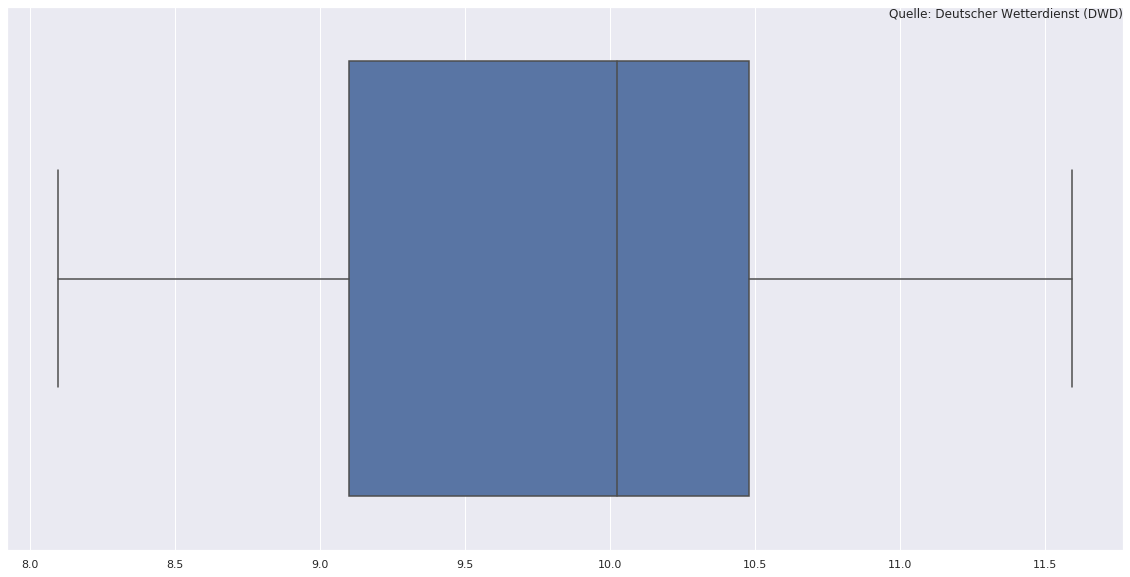

In [30]:
add_source(sns.boxplot(x=temp_df))



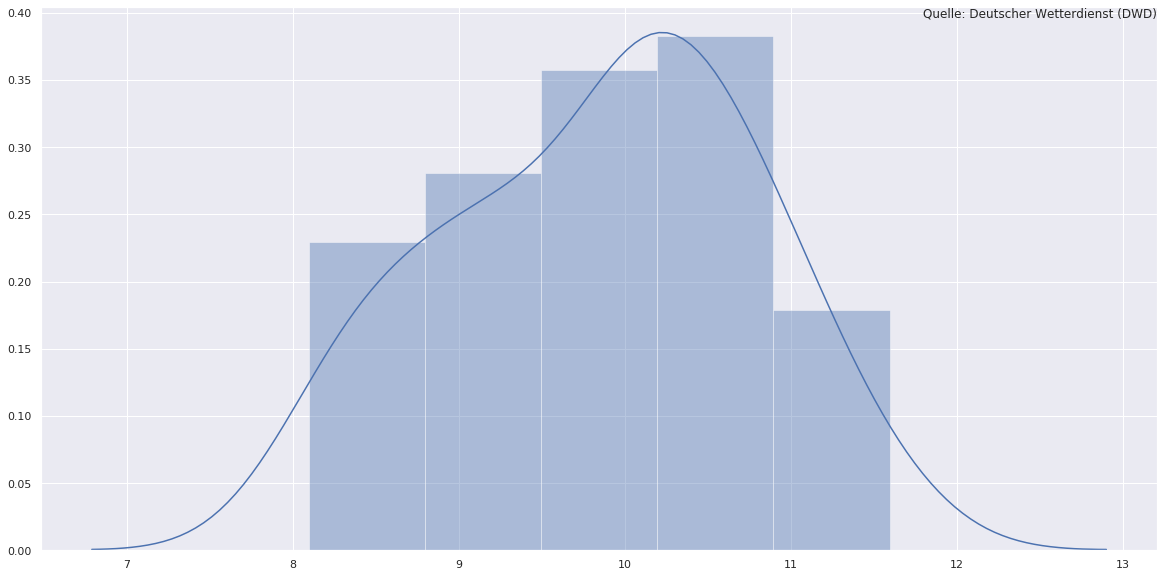

In [31]:
add_source(sns.distplot(temp_df))


 Auch wenn die durchschnittliche Jahrestemperatur stark schwankt, sind doch steigende Temperaturen erkennbar.

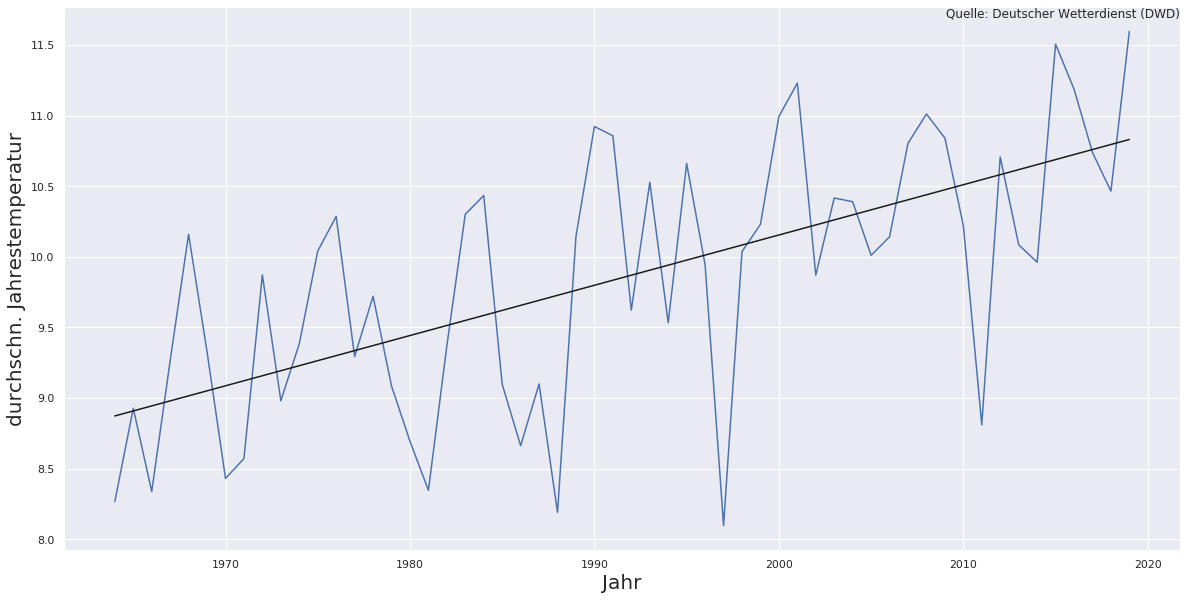

In [32]:
temp = sns.lineplot(data=temp_df, legend=False)
temp.set_xlabel('Jahr', fontsize=20)
temp.set_ylabel('durchschn. Jahrestemperatur', fontsize=20)
add_source(temp)

x = np.arange(temp_df['TMK'].size)
fit = np.polyfit(x, temp_df['TMK'], 1)
fit_fn = np.poly1d(fit)

temp.plot(temp_df.index, fit_fn(x), 'k-')



In [33]:
stat, p = shapiro(temp_df['TMK'])
alpha = 0.05
if p > alpha:
    print('Die jährliche Durschnittstemperatur ist wahrscheinlich normalverteilt.')
else:
    print('Die jährliche Durchschnittstemperatur ist nicht normalverteilt.')


Die jährliche Durschnittstemperatur ist wahrscheinlich normalverteilt.


 Bei den Regenwerten (RSK) ist die jährliche Regenmenge interessanter als die täglichen Einzelwerte.

In [34]:
regen_df = df[['RSK']].resample('Y').sum()
regen_df.head(5)



,RSK
MESS_DATUM,
1963-12-31,464.1
1964-12-31,482.2
1965-12-31,630.6
1966-12-31,752.3
1967-12-31,634.3


In [35]:
regen_df.describe()



,RSK
count,56.000000
mean,549.101786
std,104.560831
min,351.200000
25%,464.075000
50%,545.650000
75%,617.450000
max,858.200000


In [36]:
regen_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 1963-12-31 to 2018-12-31
Freq: A-DEC
Data columns (total 1 columns):
RSK    56 non-null float64
dtypes: float64(1)
memory usage: 896.0 bytes


 Das folgende Histogramm deutet daraufhin, dass die jährliche Regenmenge normalverteilt ist.

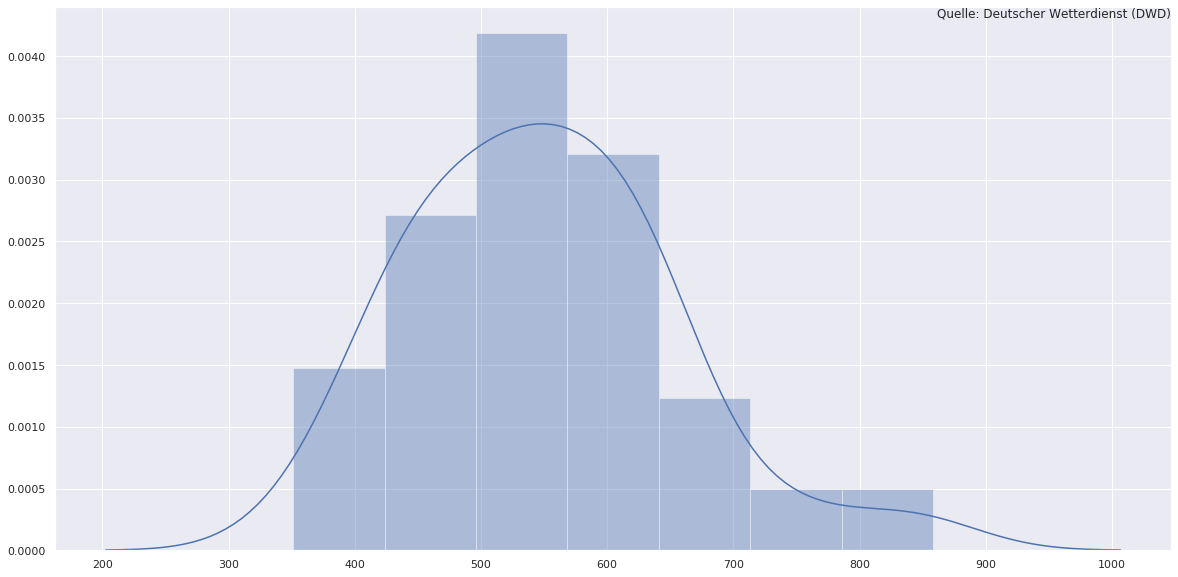

In [37]:
add_source(sns.distplot(regen_df))


 Auch in folgendem Plot kann ich keine steigende oder sinkende Regenmenge abgelesen.

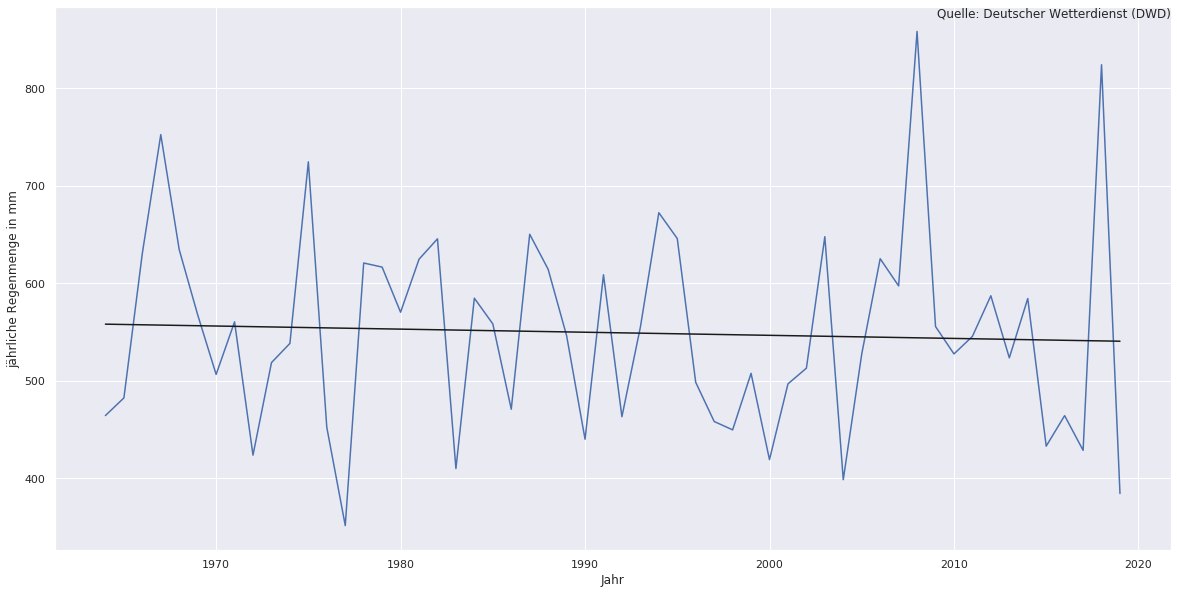

In [38]:
regen = sns.lineplot(data=regen_df, legend=False)
regen.set_xlabel('Jahr')
regen.set_ylabel('jährliche Regenmenge in mm')
add_source(regen)

x = np.arange(regen_df['RSK'].size)
fit = np.polyfit(x, regen_df['RSK'], 1)
fit_fn = np.poly1d(fit)
regen.plot(regen_df.index, fit_fn(x), 'k-')


 Ich nutze den Shapiro-Wilk Test, um die jährliche Regenmenge auf Normalverteilung zu testen.

In [39]:
stat, p = shapiro(regen_df['RSK'])
alpha = 0.05
if p > alpha:
    print('Die jährliche Regenmenge ist wahrscheinlich normalverteilt.')
else:
    print('Die jährliche Regenmenge ist nicht normalverteilt.')


Die jährliche Regenmenge ist wahrscheinlich normalverteilt.
